In [7]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
np.random.seed(42)

In [19]:
# Edinburgh
from data_processing import read_edinburgh_data 
data, agent_ids = read_edinburgh_data()

/Users/kriis/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2342/2342 [01:00<00:00, 38.52it/s]


Warning! too big dt in [Edinburgh]
finish


In [130]:
def agent_data(data, agent_id):
    x = data["pos_x"].loc[data["agent_id"]==agent_id].values
    y = data["pos_y"].loc[data["agent_id"]==agent_id].values

    max_train_idx = len(x)-10
    
    return x, y, max_train_idx

# Sample train and test data for pos_x and pos_y, each slice with num_steps length
def generate_data(data, begin_idx, agent_id, num_steps=5):
    sample_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values
    sample_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values

    test_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    test_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    
    return sample_x, sample_y, test_x, test_y
    
def calculate_FDE(pred_x, pred_y, test_x, test_y):

    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    return FDE

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [143]:
def plot_whole_trajectories(sample_x, sample_y, pred_x, pred_y, random_start_idx):
    plt.figure(figsize=(8, 8))
    plt.axes().set_aspect('equal')
        
    plt.plot(sample_x, sample_y, color='g', linewidth=2)
    plt.scatter(sample_x, sample_y, color='g', linewidth=2)

    plt.plot(pred_x, pred_y, color='r')
    plt.scatter(pred_x, pred_y, color='r')

    plt.scatter(sample_x[0], sample_y[0], color='b')
    
    plt.plot(sample_x[random_start_idx:random_start_idx+5], sample_y[random_start_idx:random_start_idx+5], c='yellow')
    plt.scatter(sample_x[random_start_idx:random_start_idx+5], sample_y[random_start_idx:random_start_idx+5], c='yellow')

    plt.show()
    
    
def plot_predictions(sample_x, sample_y, test_x, test_y, pred_x, pred_y):
    plt.axes().set_aspect('equal')
        
    plt.plot(np.append(sample_x, pred_x), np.append(sample_y, pred_y), label="fitted polynomial", color='r')
    plt.scatter(pred_x, pred_y, color='r')
    
    plt.plot(np.append(sample_x, test_x), np.append(sample_y, test_y), label="actual data", color='g')
    plt.scatter(np.append(sample_x, test_x), np.append(sample_y, test_y), color='g')

    plt.scatter(sample_x[0], sample_y[0], color='b')
    plt.scatter(sample_x[-1], sample_y[-1], color='gray')
    plt.scatter(pred_x[0], pred_y[0], color='r')

    plt.show()
    
def plot_multiple_trajectories(sample_x, sample_y, test_x, test_y, pred_x_list, pred_y_list):
    assert len(pred_x_list) == len(pred_y_list)
    plt.axes().set_aspect('equal')
        
    for i in range(len(pred_x_list)):
        plt.plot(pred_x_list[i], pred_y_list[i])
        plt.scatter(pred_x_list[i], pred_y_list[i])
    
    plt.plot(np.append(sample_x, test_x), np.append(sample_y, test_y), label="actual data", color='g')
    plt.scatter(np.append(sample_x, test_x), np.append(sample_y, test_y), color='g')

    plt.scatter(sample_x[0], sample_y[0], color='b')
    plt.scatter(sample_x[-1], sample_y[-1], color='gray')
    plt.scatter(pred_x[0], pred_y[0], color='r')

    plt.show()

In [8]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

### Avg vel + avg rotation

In [151]:
def avg_vel_const(sample_x, sample_y, noise_var):
    sample_vel_x = [(sample_x[i] - sample_x[i-1]) + np.random.normal(0, noise_var) for i in range(1, len(sample_x))]
    sample_vel_y = [(sample_y[i] - sample_y[i-1]) + np.random.normal(0, noise_var) for i in range(1, len(sample_y))]
    
    avg_vel_x = np.mean(sample_vel_x)
    avg_vel_y = np.mean(sample_vel_y)
    
    pred_x = [sample_x[-1] + i*avg_vel_x for i in range(1, 6)]
    pred_y = [sample_y[-1] + i*avg_vel_y for i in range(1, 6)]
    
    return pred_x, pred_y

In [156]:
def avg_vel_and_rot_const(sample_x, sample_y, noise_var):
    print("==================")
    sample_vel_x = [(sample_x[i] - sample_x[i-1]) + np.random.normal(0, noise_var) for i in range(1, len(sample_x))]
    sample_vel_y = [(sample_y[i] - sample_y[i-1]) + np.random.normal(0, noise_var) for i in range(1, len(sample_y))]
    
    all_angles = []
    for i in range(1, len(sample_vel_x)):
        prev_vel = [sample_vel_x[i-1], sample_vel_y[i-1]]
        curr_vel = [sample_vel_x[i], sample_vel_y[i]]
        one_angle = np.math.atan2(np.linalg.det([prev_vel, curr_vel]),np.dot(prev_vel, curr_vel))   
        all_angles.append(one_angle)
    
    avg_angle = np.mean(all_angles)
    
    avg_vel_x = np.mean(sample_vel_x)
    avg_vel_y = np.mean(sample_vel_y)
    
    pred_x = [sample_x[-1] + i*avg_vel_x for i in range(1, 6)]
    pred_y = [sample_y[-1] + i*avg_vel_y for i in range(1, 6)]

    rot_pred_x = [pred_x[0]]
    rot_pred_y = [pred_y[0]]
    rot_pred_x[0] = sample_x[-1] + math.cos(avg_angle) * (rot_pred_x[0] - sample_x[-1]) - math.sin(avg_angle) * (rot_pred_y[0] - sample_y[-1])
    rot_pred_y[0] = sample_y[-1] + math.sin(avg_angle) * (rot_pred_x[0] - sample_x[-1]) + math.cos(avg_angle) * (rot_pred_y[0] - sample_y[-1])
    for i in range(1, 5):

        rot_pred_x.append(rot_pred_x[-1] + avg_vel_x)
        rot_pred_y.append(rot_pred_y[-1] + avg_vel_y)
        
        prev_x = rot_pred_x[i-1]
        cur_x = rot_pred_x[i]
        prev_y = rot_pred_y[i-1]
        cur_y = rot_pred_y[i]
        
        rot_x, rot_y = rotate((prev_x, prev_y), (cur_x, cur_y), avg_angle)
        
        rot_pred_x[i] = rot_x
        rot_pred_y[i] = rot_y
        
        # redefine the average velocity as it now has a new heading
        avg_vel_x = rot_x - prev_x
        avg_vel_y = rot_y - prev_y
    
    return pred_x, pred_y, rot_pred_x, rot_pred_y

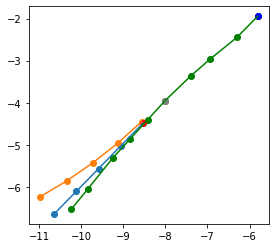

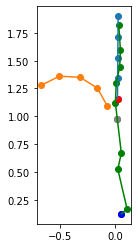

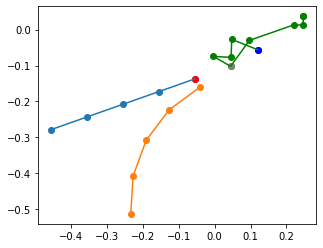

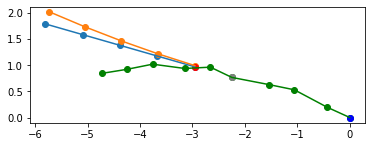

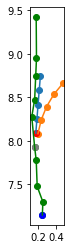

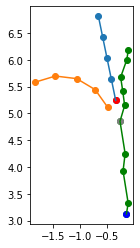

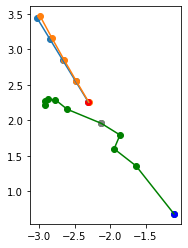

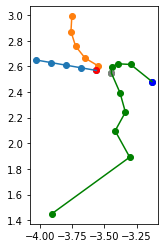

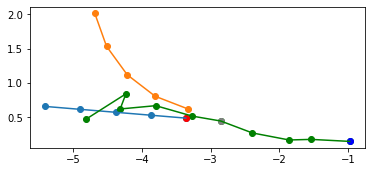

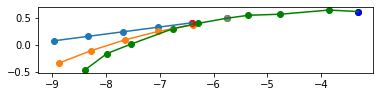

In [157]:
for agent_id in agent_ids[:10]:
    x_data, y_data, max_train_idx = agent_data(data, agent_id)
    random_start_idx = np.random.randint(0, max_train_idx)
    sample_x, sample_y, test_x, test_y = generate_data(data, random_start_idx, agent_id, 5)
    
    pred_x, pred_y, rot_pred_x, rot_pred_y = avg_vel_and_rot_const(sample_x, sample_y, 0.1)
    
    plot_multiple_trajectories(sample_x, sample_y, test_x, test_y, [pred_x, rot_pred_x], [pred_y, rot_pred_y])
    #plot_predictions(sample_x, sample_y, test_x, test_y, rot_pred_x, rot_pred_y)

### Avg vel + last rotation

In [126]:
def avg_vel_and_last_rot_const(sample_x, sample_y, noise_var):
    print("==================")
    sample_vel_x = [(sample_x[i] - sample_x[i-1]) + np.random.normal(0, noise_var) for i in range(1, len(sample_x))]
    sample_vel_y = [(sample_y[i] - sample_y[i-1]) + np.random.normal(0, noise_var) for i in range(1, len(sample_y))]
    
    prev_vel = [sample_vel_x[-2], sample_vel_y[-2]]
    curr_vel = [sample_vel_x[-1], sample_vel_y[-1]]
    last_angle = np.math.atan2(np.linalg.det([prev_vel, curr_vel]),np.dot(prev_vel, curr_vel))   
    
    avg_vel_x = np.mean(sample_vel_x)
    avg_vel_y = np.mean(sample_vel_y)
    
    pred_x = [sample_x[-1] + i*avg_vel_x for i in range(1, 6)]
    pred_y = [sample_y[-1] + i*avg_vel_y for i in range(1, 6)]

    rot_pred_x = [pred_x[0]]
    rot_pred_y = [pred_y[0]]
    rot_pred_x[0] = sample_x[-1] + math.cos(last_angle) * (rot_pred_x[0] - sample_x[-1]) - math.sin(last_angle) * (rot_pred_y[0] - sample_y[-1])
    rot_pred_y[0] = sample_y[-1] + math.sin(last_angle) * (rot_pred_x[0] - sample_x[-1]) + math.cos(last_angle) * (rot_pred_y[0] - sample_y[-1])
    for i in range(1, 5):

        rot_pred_x.append(rot_pred_x[-1] + avg_vel_x)
        rot_pred_y.append(rot_pred_y[-1] + avg_vel_y)
        
        prev_x = rot_pred_x[i-1]
        cur_x = rot_pred_x[i]
        prev_y = rot_pred_y[i-1]
        cur_y = rot_pred_y[i]
        
        rot_x = prev_x + math.cos(last_angle*i) * (cur_x - prev_x) - math.sin(last_angle*i) * (cur_y - prev_y)
        rot_y = prev_y + math.sin(last_angle*i) * (cur_x - prev_x) + math.cos(last_angle*i) * (cur_y - prev_y)
        
        rot_pred_x[i] = rot_x
        rot_pred_y[i] = rot_y
    
    return pred_x, pred_y, rot_pred_x, rot_pred_y

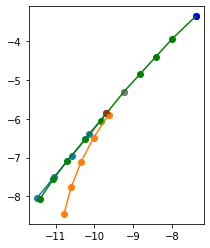

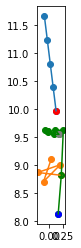

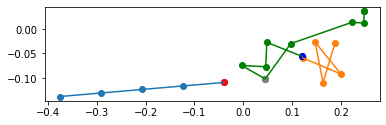

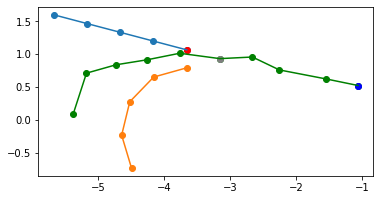

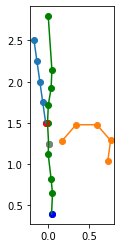

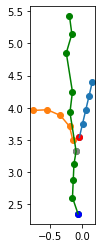

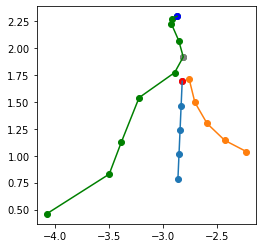

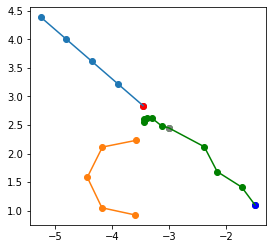

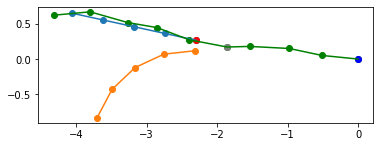

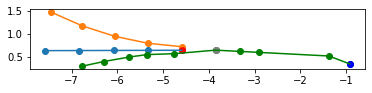

In [128]:
for agent_id in agent_ids[:10]:
    x_data, y_data, max_train_idx = agent_data(data, agent_id)
    random_start_idx = np.random.randint(0, max_train_idx)
    sample_x, sample_y, test_x, test_y = generate_data(data, random_start_idx, agent_id, 5)
    
    pred_x, pred_y, rot_pred_x, rot_pred_y = avg_vel_and_last_rot_const(sample_x, sample_y, 0.1)
    
    plot_multiple_trajectories(sample_x, sample_y, test_x, test_y, [pred_x, rot_pred_x], [pred_y, rot_pred_y])
    #plot_predictions(sample_x, sample_y, test_x, test_y, rot_pred_x, rot_pred_y)

### Random tests with rotation

In [146]:
# https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python
p0 = [3.5, 6.7]
p1 = [7.9, 8.4]
p2 = [10.8, 4.8]

''' 
compute angle (in degrees) for p0p1p2 corner
Inputs:
    p0,p1,p2 - points in the form of [x,y]
'''

v0 = np.array(p0) - np.array(p1)
v1 = np.array(p2) - np.array(p1)

angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
print(v0)
print(v1)
print(np.degrees(angle))

[-4.4 -1.7]
[ 2.9 -3.6]
107.72865519428085


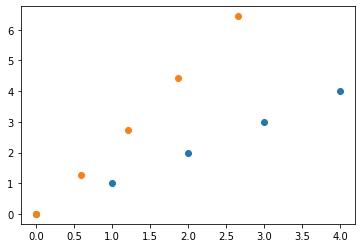

[0, 1, 2, 3, 4]
[0, 0.5976724774602398, 1.210211548109556, 1.8741813696753555, 2.6536736255019573]


In [145]:
a = [0,1,2,3,4]
b = [0,1,2,3,4]

a_rot = [0, 1, 2, 3, 4]
b_rot = [0, 1, 2, 3, 4]

plt.scatter(a, b)

for i in range(1, len(a)):
    prev_a = a_rot[i-1]
    cur_a = a_rot[i]
    prev_b = b_rot[i-1]
    cur_b = b_rot[i]
    
    rot_a, rot_b = rotate((prev_a, prev_b), (cur_a, cur_b), math.radians(20*i))
    a_rot[i] = rot_a
    b_rot[i] = rot_b
    
plt.scatter(a_rot, b_rot)
plt.show()

print(a)
print(a_rot)